# Online Payment Fraud Detection

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

## Data Preprocessing

In [2]:
# Load dataset
dataset = pd.read_csv('../datasets/onlinefraud.csv')
# Drop unnecessary columns
dataset.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'], inplace=True)
dataset.head(10)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.00,160296.36,0.0,0.00,0
1,1,PAYMENT,1864.28,21249.00,19384.72,0.0,0.00,0
2,1,TRANSFER,181.00,181.00,0.00,0.0,0.00,1
3,1,CASH_OUT,181.00,181.00,0.00,21182.0,0.00,1
4,1,PAYMENT,11668.14,41554.00,29885.86,0.0,0.00,0
5,1,PAYMENT,7817.71,53860.00,46042.29,0.0,0.00,0
6,1,PAYMENT,7107.77,183195.00,176087.23,0.0,0.00,0
7,1,PAYMENT,7861.64,176087.23,168225.59,0.0,0.00,0
8,1,PAYMENT,4024.36,2671.00,0.00,0.0,0.00,0
9,1,DEBIT,5337.77,41720.00,36382.23,41898.0,40348.79,0


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
 7   isFraud         int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 388.3+ MB


In [4]:
dataset.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


In [5]:
# Analyse classes (Valid/Fraud) - Possible imbalanced dataset
data_fraud = dataset[dataset.isFraud == 1]
data_valid = dataset[dataset.isFraud == 0]

print(f"Valid Transactions: {len(data_valid)}")
print(f"Valid Transactions (%): {round(len(data_valid)/len(dataset) * 100, 2)}%")
print(f"Fraudulent Transactions: {len(data_fraud)}")
print(f"Fraudulant Transactions (%): {round(len(data_fraud)/len(dataset) * 100, 2)}%")

Valid Transactions: 6354407
Valid Transactions (%): 99.87%
Fraudulent Transactions: 8213
Fraudulant Transactions (%): 0.13%


In [6]:
# Analyse the 'type' column
dataset.type.describe()

count      6362620
unique           5
top       CASH_OUT
freq       2237500
Name: type, dtype: object

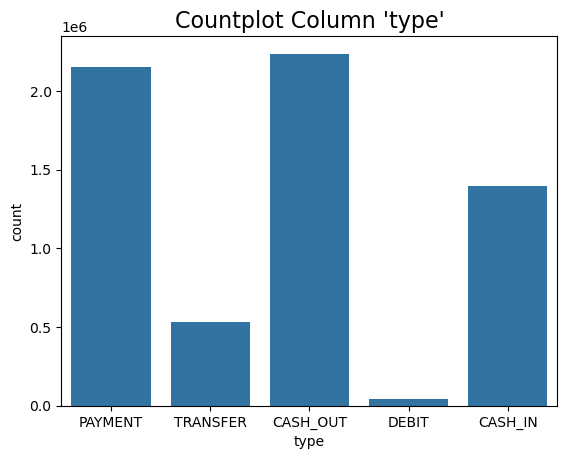

In [7]:
# Countplot for column "type"
sns.countplot(data=dataset, x='type') 
plt.title("Countplot Column 'type'", fontsize=16)
plt.show()

In [8]:
# Encode categorical feature "type" 
type_ohe = pd.get_dummies(data=dataset.type, dtype=float) # drop_first=True
dataset_ohe = pd.concat([dataset, type_ohe], axis=1)
dataset_ohe.drop(columns=['type'], inplace=True)
dataset_ohe.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0
2,1,181.00,181.0,0.00,0.0,0.0,1,0.0,0.0,0.0,0.0,1.0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0.0,1.0,0.0,0.0,0.0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0


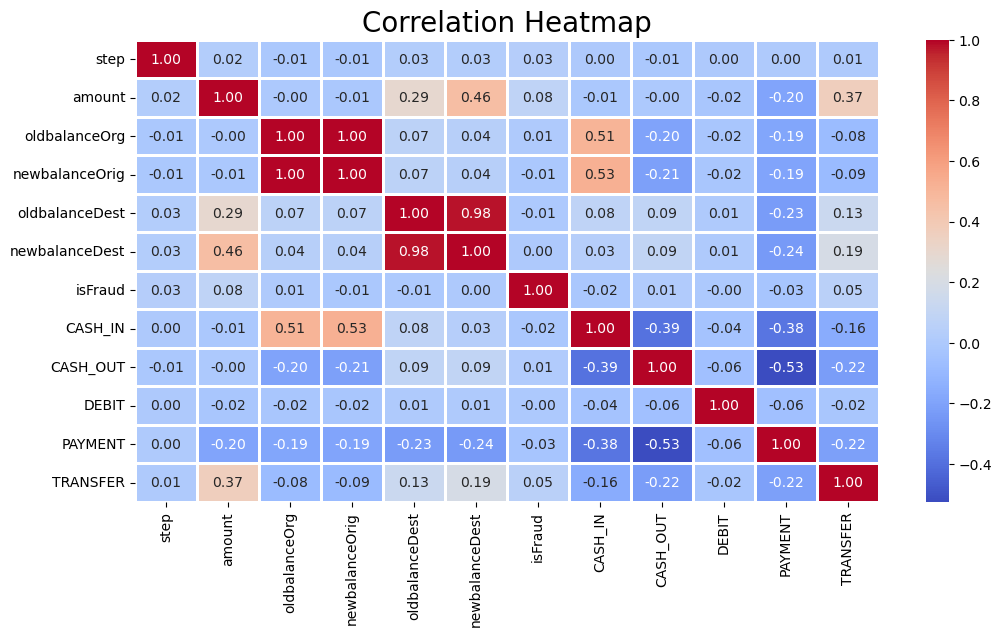

In [9]:
# Correlation heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(dataset_ohe.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=2) 
plt.title("Correlation Heatmap", fontsize=20)
plt.show()

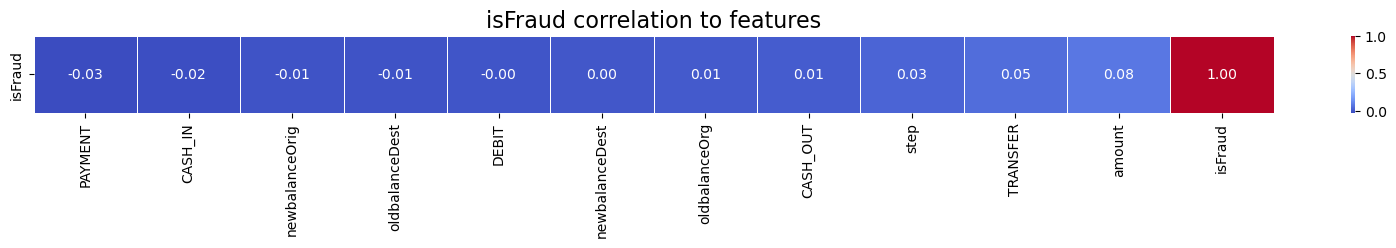

In [10]:
# Correlation for "isFraud"
amount_class_corr = pd.DataFrame(dataset_ohe.corr()[['isFraud']].sort_values(by=['isFraud'], ascending=True))
plt.figure(figsize=(20, 1))
sns.heatmap(amount_class_corr.T, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5) 
plt.title("isFraud correlation to features", fontsize=16)
plt.show()

/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = ge

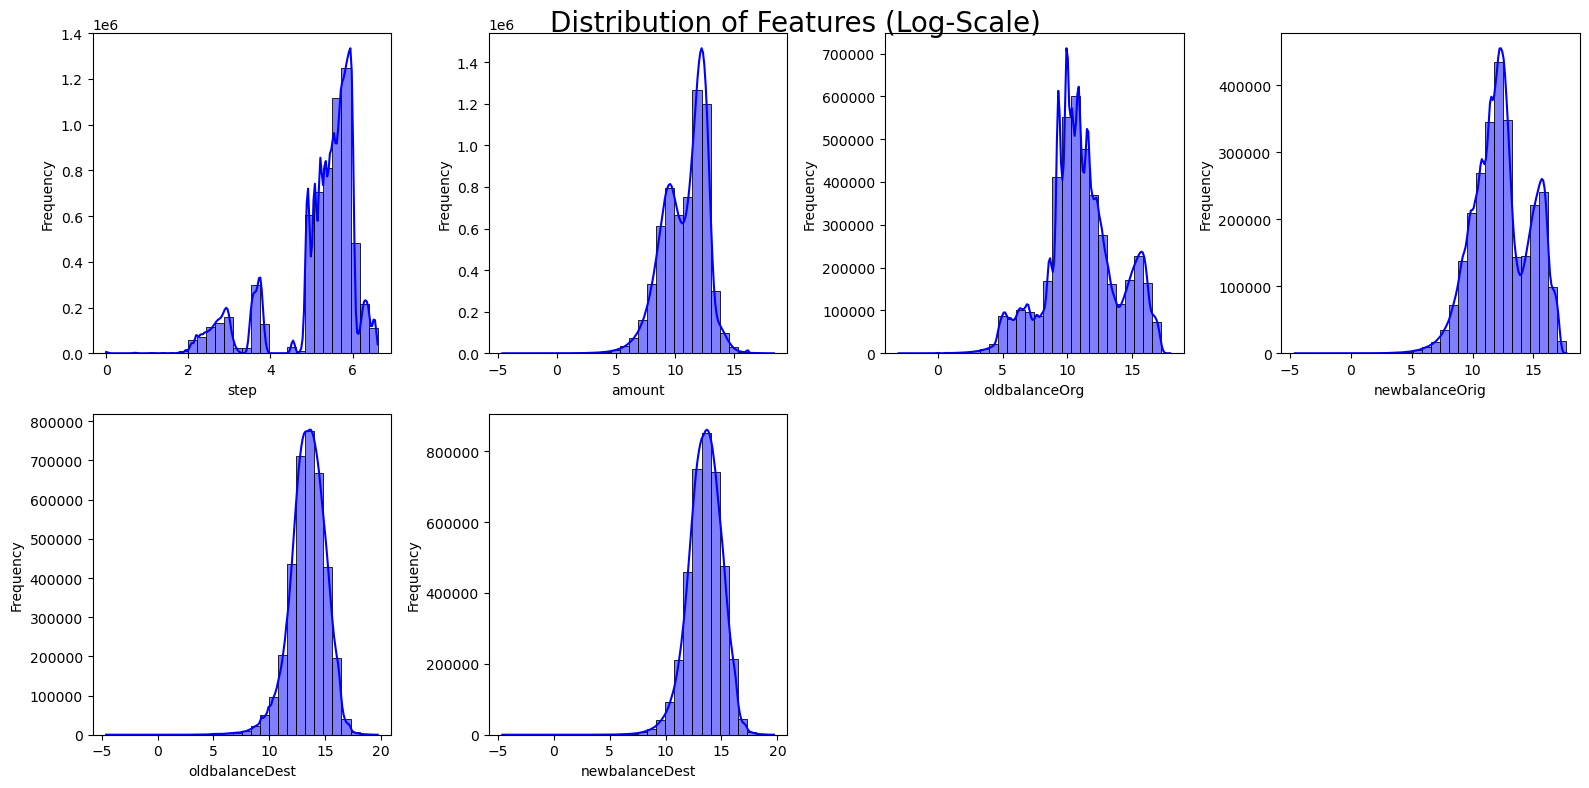

In [11]:
# Distribution of each feature 
num_features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
fig, axes = plt.subplots(nrows=len(num_features)//4 + 1, ncols=4, figsize=(16, 8))
axes = axes.flatten()
for i, feature in enumerate(num_features):
    sns.histplot(np.log(dataset_ohe[feature]), kde=True, bins=30, color='blue', ax=axes[i])
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Frequency")
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
fig.suptitle("Distribution of Features (Log-Scale)", fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

## Model Training & Evaluation (No data balancing)

In [12]:
# Extract features and targets - First attempt: No data balancing
Y = np.array(dataset_ohe.isFraud)
X = np.array(dataset_ohe.drop(columns=['isFraud']))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [13]:
# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# Dictionary of models to train
models = {
    "Logistic Regression (Sklearn)": LogisticRegression(),
    "XGBoost": XGBClassifier() 
}

In [15]:
# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    
    # Compute performance metrics
    acc = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    results[name] = {"Accuracy": acc, "F1-Score": f1,
                     "Precision": precision, "Recall": recall
                     }

    print(f"\n{name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision-Score: {precision:.4f}")
    print(f"Recall-Score: {recall:.4f}")


Logistic Regression (Sklearn):
Accuracy: 0.9992
F1-Score: 0.5759
Precision-Score: 0.8785
Recall-Score: 0.4284

XGBoost:
Accuracy: 0.9998
F1-Score: 0.9130
Precision-Score: 0.9630
Recall-Score: 0.8679


In [16]:
# Compare model performance
print("\nModel Performance Comparison:")
performance_df = pd.DataFrame(results).T
print(performance_df)


Model Performance Comparison:
                               Accuracy  F1-Score  Precision    Recall
Logistic Regression (Sklearn)  0.999197  0.575934   0.878481  0.428395
XGBoost                        0.999789  0.912987   0.963014  0.867901



Best Model: XGBoost


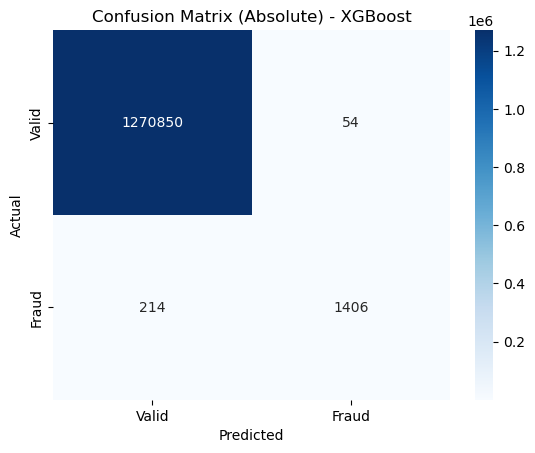

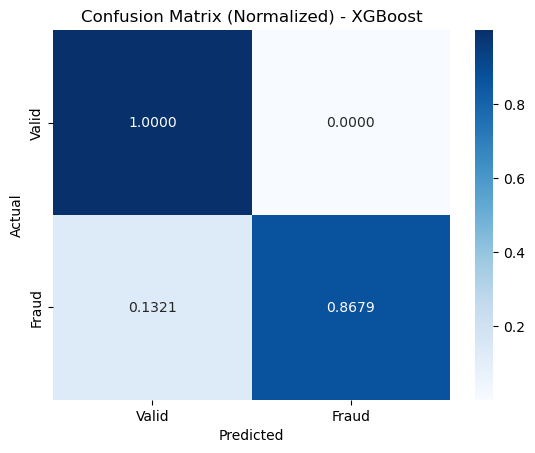

In [17]:
# Visualization of predictions for the best model, Confusion matrix
best_model_name = performance_df["F1-Score"].idxmax()
print(f"\nBest Model: {best_model_name}")

best_model = models[best_model_name]
best_pred = best_model.predict(X_test)

conf_matrix = confusion_matrix(Y_test, best_pred)

# Plot the confusion matrix (absolute values)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Valid", "Fraud"], yticklabels=["Valid", "Fraud"])
plt.title(f"Confusion Matrix (Absolute) - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
# Plot the confusion matrix (normalized values)
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".4f", cmap="Blues", xticklabels=["Valid", "Fraud"], yticklabels=["Valid", "Fraud"])
plt.title(f"Confusion Matrix (Normalized) - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

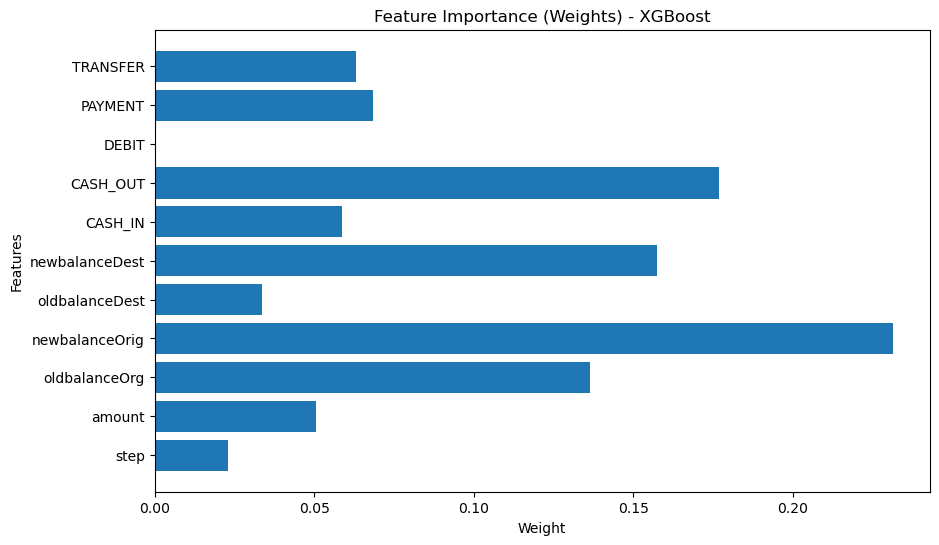

In [18]:
# Plot feature importance (weights) if XGBoost is the best model
if best_model_name == "XGBoost":
    feature_importance = best_model.feature_importances_
    feature_names = dataset_ohe.drop(columns=['isFraud']).columns
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_importance)), feature_importance, align="center")
    plt.yticks(range(len(feature_importance)), feature_names)
    plt.title(f"Feature Importance (Weights) - {best_model_name}")
    plt.xlabel("Weight")
    plt.ylabel("Features")
    plt.show()

## Model Training & Evaluation (Handling Imbalanced Dataset)

In [19]:
# Extract features and targets - Stratify
Y = np.array(dataset_ohe.isFraud)
X = np.array(dataset_ohe.drop(columns=['isFraud']))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y,random_state=42)

In [20]:
# Apply SMOTE for oversampling of minority class
#smote = SMOTE(sampling_strategy='auto', random_state=42)
#X_train, Y_train = smote.fit_resample(X_train, Y_train)

In [21]:
# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
# Dictionary of models to train
models = {
    "Logistic Regression (Sklearn)": LogisticRegression(class_weight='balanced'),
    "XGBoost": XGBClassifier(scale_pos_weight=len(data_valid)/len(data_fraud))
}

In [23]:
# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    
    # Compute performance metrics with weighted averaging
    acc = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    results[name] = {"Accuracy": acc, "F1-Score": f1,
                     "Precision": precision, "Recall": recall}

    print(f"\n{name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision-Score: {precision:.4f}")
    print(f"Recall-Score: {recall:.4f}")


Logistic Regression (Sklearn):
Accuracy: 0.9492
F1-Score: 0.0465
Precision-Score: 0.0238
Recall-Score: 0.9610

XGBoost:
Accuracy: 0.9985
F1-Score: 0.6304
Precision-Score: 0.4628
Recall-Score: 0.9884


In [24]:
# Compare model performance
print("\nModel Performance Comparison:")
performance_df = pd.DataFrame(results).T
print(performance_df)


Model Performance Comparison:
                               Accuracy  F1-Score  Precision    Recall
Logistic Regression (Sklearn)  0.949155  0.046537   0.023846  0.961047
XGBoost                        0.998504  0.630435   0.462810  0.988436



Best Model: XGBoost


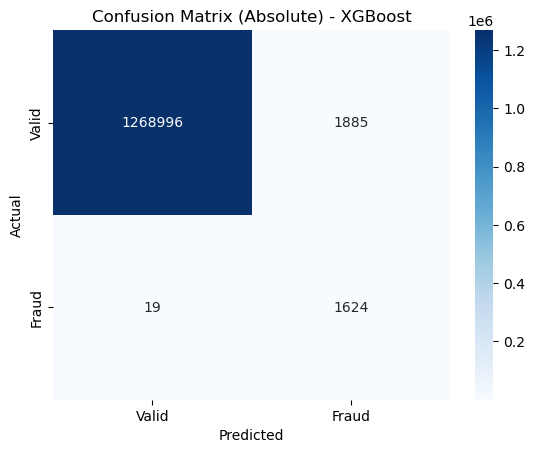

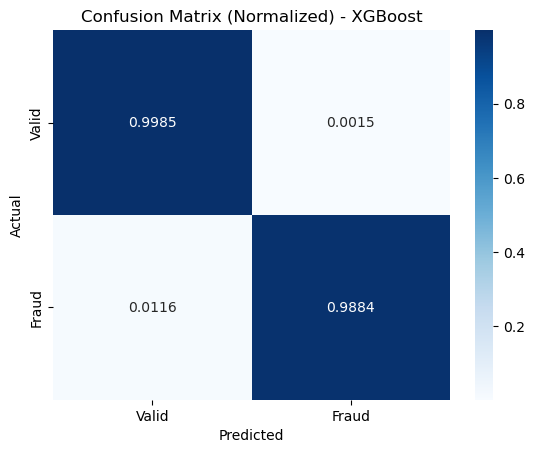

In [25]:
# Visualization of predictions for the best model, Confusion matrix
best_model_name = performance_df["F1-Score"].idxmax()
print(f"\nBest Model: {best_model_name}")

best_model = models[best_model_name]
best_pred = best_model.predict(X_test)

conf_matrix = confusion_matrix(Y_test, best_pred)

# Plot the confusion matrix (absolute values)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Valid", "Fraud"], yticklabels=["Valid", "Fraud"])
plt.title(f"Confusion Matrix (Absolute) - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
# Plot the confusion matrix (normalized values)
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".4f", cmap="Blues", xticklabels=["Valid", "Fraud"], yticklabels=["Valid", "Fraud"])
plt.title(f"Confusion Matrix (Normalized) - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

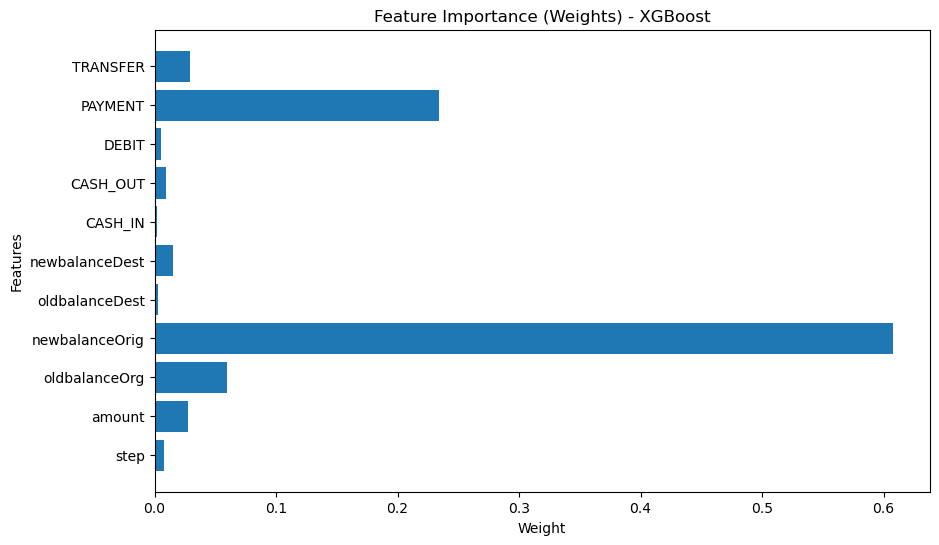

In [26]:
# Plot feature importance (weights) if XGBoost is the best model
if best_model_name == "XGBoost":
    feature_importance = best_model.feature_importances_
    feature_names = dataset_ohe.drop(columns=['isFraud']).columns
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_importance)), feature_importance, align="center")
    plt.yticks(range(len(feature_importance)), feature_names)
    plt.title(f"Feature Importance (Weights) - {best_model_name}")
    plt.xlabel("Weight")
    plt.ylabel("Features")
    plt.show()